In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
sys.path.append('..\model')
from Cylinder_Yaxis_1Layer import Cylinder_Yaxis_1Layer

model=Cylinder_Yaxis_1Layer()

mesh=model.mesh
Draw(mesh)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [2]:

symmetric_plane=model.symmetric_plane
Mu=model.Mu
reduced_region=model.reduced_region
total_region=model.total_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary

Dirichlet=False
feorder=3
coil=UNIF(0,1,0,2)
Av=Afield(coil)
Bv=Bfield(coil)
mu=4.e-7*math.pi
Hv=Bv/mu
As=model.ReducedField(Av, (0,0,0))
Bs=model.ReducedField(Bv, (0,0,0))

if Dirichlet==True:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane+'|'+reduced_boundary, nograds=True)
else:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane, nograds=True) 
A,N = fesA.TnT() 
gfA = GridFunction(fesA)
normal = specialcf.normal(mesh.dim)

a= BilinearForm(fesA)
a +=1/Mu*curl(A)*curl(N)*dx
with TaskManager():
    a.Assemble()

# Calculate Dirichlet condition terms
gfA.Set(Av, BND, mesh.Boundaries(total_boundary))
f = LinearForm(fesA)
f +=1/Mu*curl(gfA)*curl(N)*dx(reduced_region)
with TaskManager():
    f.Assemble()    
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesA.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesA.FreeDofs()] = fcut

# Add Neumann condition terms
f += Cross(N.Trace(),Hv)*normal*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfA = GridFunction(fesA)   #Clear gfA
gfA=solver.iccg_solve(fesA, gfA, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, complex=False) 

fesAt=HCurl(mesh, order=feorder, definedon=total_region, dirichlet=symmetric_plane, nograds=True)
fesAr=HCurl(mesh, order=feorder, definedon=reduced_region, dirichlet=symmetric_plane, nograds=True)
At=GridFunction(fesAt)
Arr=GridFunction(fesAr)
Axr=GridFunction(fesAr)
At.Set(gfA,VOL, definedon=total_region)
Arr.Set(gfA,VOL, definedon=reduced_region)
Axr.Set(Av, BND, mesh.Boundaries(total_boundary))

Bt=curl(At)
Ar=Arr-Axr
Br=curl(Arr)-curl(Axr)

print("**** A field ****")
Afield=At+Ar+As
Draw (Afield, mesh, order=3, min=-1.0, max=1.0, deformation=False)  
print("**** B field ****")
Bfield=Bt+Br+Bs
Draw (Bfield, mesh, order=3, min=0., max=1.2, deformation=False) 

mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))


enter iccg_solve
Dof= 35925    matrix size= 1797797.0
結果のノルム: 1.5414308572307735e-15
power=  74427.59237560321
**** A field ****


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

**** B field ****


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

center magnetic field =  (7.236731087298752e-08, 1.8331805495970313, 2.138892077548991e-15)


Dirichlet=False

center magnetic field =  (7.236731087298752e-08, 1.8331805495970313, 2.138892077548991e-15)

B field
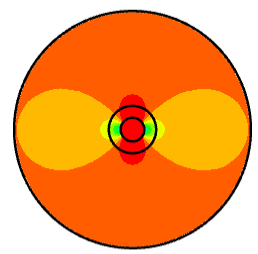

Dirichlet=True

center magnetic field =  (7.003348044725892e-08, 1.8034265356606107, -7.107378125217459e-16)

B field
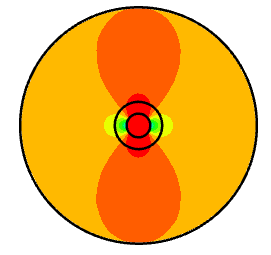